In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns

In [2]:
# Paths and constants
DATA_PATH = "data"
ACTIVITIES = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10",
    "A11", "A12", "A13", "A14", "A15", "A16", "A17", "A18", "A19"
]
NUM_COLUMNS = 45  # Total sensor columns

# Data Preparation

In [3]:
# Function to load data into a list
def load_data_to_dataframe(data_path):
    data_records = []
    for activity_idx, activity in enumerate(ACTIVITIES, start=1):
        activity_folder = os.path.join(data_path, f"a{activity_idx:02d}")
        for subject in os.listdir(activity_folder):
            subject_folder = os.path.join(activity_folder, subject)
            for segment_file in os.listdir(subject_folder):
                segment_path = os.path.join(subject_folder, segment_file)
                segment_data = np.loadtxt(segment_path, delimiter=",")
                
                # Compute features (mean, std, min, max, median) for each sensor column
                features = []
                for col in range(NUM_COLUMNS):
                    col_data = segment_data[:, col]
                    features.extend([
                        np.mean(col_data),
                        np.std(col_data),
                        np.min(col_data),
                        np.max(col_data),
                        np.median(col_data)
                    ])
                
                # Append the features and label to the data records
                data_records.append(features + [activity_idx - 1])  # Zero-indexed labels
    
    # Create DataFrame with feature columns and label
    column_names = []
    for col in range(NUM_COLUMNS):
        column_names.extend([
            f"sensor_{col+1}_mean",
            f"sensor_{col+1}_std",
            f"sensor_{col+1}_min",
            f"sensor_{col+1}_max",
            f"sensor_{col+1}_median"
        ])
    column_names.append("label")
    
    return pd.DataFrame(data_records, columns=column_names)


In [4]:
# Load the data into a DataFrame
print("Loading data into DataFrame...")
df = load_data_to_dataframe(DATA_PATH)

Loading data into DataFrame...


In [5]:
# Display the DataFrame structure
print("DataFrame created. Displaying structure...")
df

DataFrame created. Displaying structure...


,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_max,sensor_1_median,sensor_2_mean,sensor_2_std,sensor_2_min,sensor_2_max,sensor_2_median,...,sensor_44_std,sensor_44_min,sensor_44_max,sensor_44_median,sensor_45_mean,sensor_45_std,sensor_45_min,sensor_45_max,sensor_45_median,label
0,7.975714,0.119500,7.6823,8.1605,7.9587,1.083150,0.046799,0.99744,1.1832,1.080700,...,0.000788,0.29968,0.30342,0.30132,-0.057119,0.000820,-0.059241,-0.054963,-0.057208,0
1,7.978250,0.086547,7.8472,8.1763,7.9367,1.140865,0.027880,1.05810,1.2129,1.139200,...,0.000857,0.29974,0.30390,0.30204,-0.057268,0.000835,-0.059589,-0.054945,-0.057405,0
2,7.970894,0.055380,7.8470,8.0860,7.9664,1.140962,0.022447,1.07960,1.2128,1.138800,...,0.000759,0.30068,0.30423,0.30261,-0.057068,0.000789,-0.059065,-0.054711,-0.057155,0
3,7.938412,0.061097,7.6901,8.1083,7.9365,1.165260,0.046424,1.07870,1.3170,1.168100,...,0.000732,0.30088,0.30416,0.30245,-0.056422,0.000891,-0.058310,-0.053670,-0.056395,0
4,7.908930,0.041563,7.8322,8.1305,7.9066,1.187504,0.025632,1.09450,1.2574,1.183300,...,0.000821,0.30041,0.30503,0.30299,-0.055801,0.000825,-0.057815,-0.053313,-0.055852,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,5.277893,-2.9038,34.1980,7.2540,-1.491537,3.814836,-11.65100,11.2240,-1.100700,...,0.200024,0.19482,0.84421,0.51129,0.297666,0.202543,-0.117430,0.708480,0.300880,18
9116,9.591118,5.952835,-3.4129,51.6970,9.4181,0.086304,2.299404,-11.76400,6.9951,0.021572,...,0.148148,0.21407,0.73991,0.52093,0.224716,0.182452,-0.250950,0.554670,0.265570,18
9117,9.599113,6.961327,-1.0765,27.9300,8.8050,-0.728367,2.374354,-8.36910,3.7801,-0.365370,...,0.309503,-0.47131,0.70910,0.15950,-0.237786,0.141771,-0.477260,0.088854,-0.262050,18
9118,9.692482,7.674849,-2.6734,72.7820,9.5237,-0.582724,2.032156,-8.85710,6.1216,-0.265470,...,0.155865,-0.17806,0.52111,0.14632,0.533023,0.115997,0.055941,0.677800,0.554610,18


In [6]:
df.isnull().sum()

sensor_1_mean       0
sensor_1_std        0
sensor_1_min        0
sensor_1_max        0
sensor_1_median     0
                   ..
sensor_45_std       0
sensor_45_min       0
sensor_45_max       0
sensor_45_median    0
label               0
Length: 226, dtype: int64

In [7]:
# Separate features and labels
X = df.drop(columns=["label"]).values
y = df["label"].values

In [8]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Classification Models

In [10]:
#Define models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42)
}



Training KNN...
KNN Accuracy: 0.98
KNN Classification Report:

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        96
          A2       1.00      1.00      1.00        96
          A3       1.00      0.99      0.99        96
          A4       1.00      1.00      1.00        96
          A5       0.98      1.00      0.99        96
          A6       0.95      1.00      0.97        96
          A7       0.87      0.97      0.92        96
          A8       0.93      0.77      0.84        96
          A9       1.00      1.00      1.00        96
         A10       1.00      1.00      1.00        96
         A11       1.00      1.00      1.00        96
         A12       1.00      1.00      1.00        96
         A13       0.98      1.00      0.99        96
         A14       0.99      1.00      0.99        96
         A15       1.00      1.00      1.00        96
         A16       1.00      1.00      1.00        96
         A17     

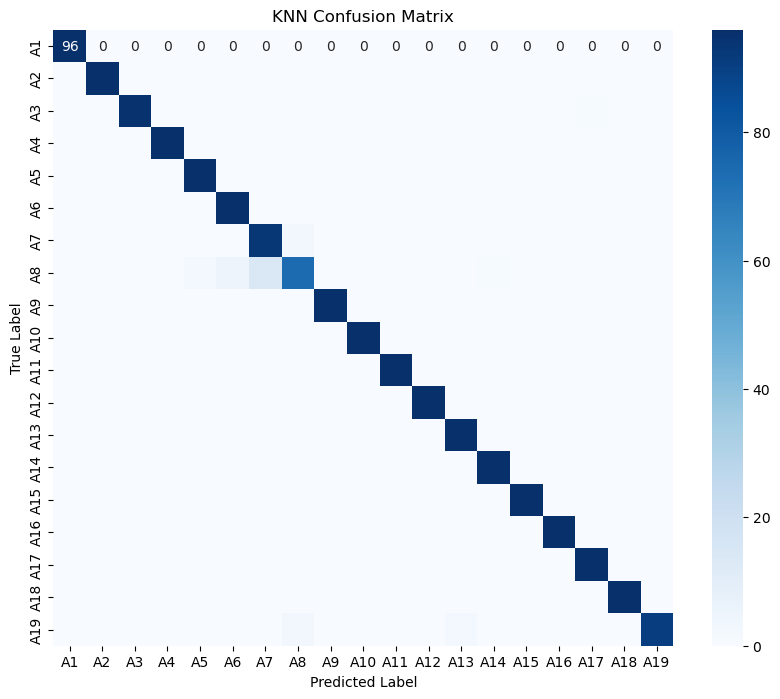


Training SVM...
SVM Accuracy: 0.99
SVM Classification Report:

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        96
          A2       0.98      1.00      0.99        96
          A3       1.00      0.98      0.99        96
          A4       1.00      1.00      1.00        96
          A5       1.00      1.00      1.00        96
          A6       0.99      1.00      0.99        96
          A7       0.90      0.96      0.93        96
          A8       0.93      0.86      0.90        96
          A9       1.00      1.00      1.00        96
         A10       1.00      1.00      1.00        96
         A11       1.00      1.00      1.00        96
         A12       1.00      1.00      1.00        96
         A13       0.99      1.00      0.99        96
         A14       1.00      0.99      0.99        96
         A15       1.00      1.00      1.00        96
         A16       1.00      1.00      1.00        96
         A17     

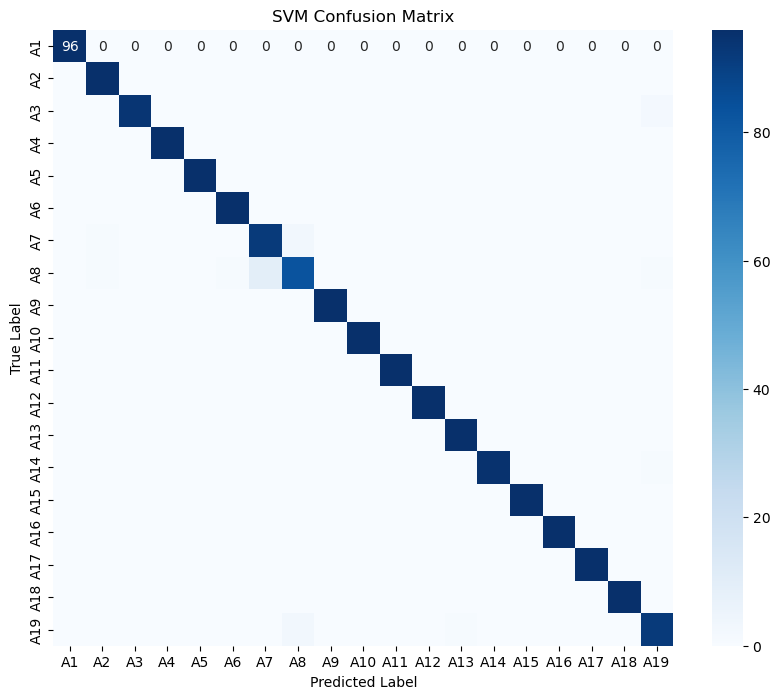


Training Decision Tree...
Decision Tree Accuracy: 0.94
Decision Tree Classification Report:

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        96
          A2       0.99      0.98      0.98        96
          A3       1.00      1.00      1.00        96
          A4       1.00      1.00      1.00        96
          A5       0.98      0.93      0.95        96
          A6       1.00      1.00      1.00        96
          A7       0.93      0.98      0.95        96
          A8       0.89      0.79      0.84        96
          A9       0.97      0.91      0.94        96
         A10       0.82      0.89      0.85        96
         A11       0.62      0.86      0.72        96
         A12       1.00      0.99      0.99        96
         A13       0.94      0.75      0.83        96
         A14       0.97      0.97      0.97        96
         A15       1.00      1.00      1.00        96
         A16       1.00      1.00      1.

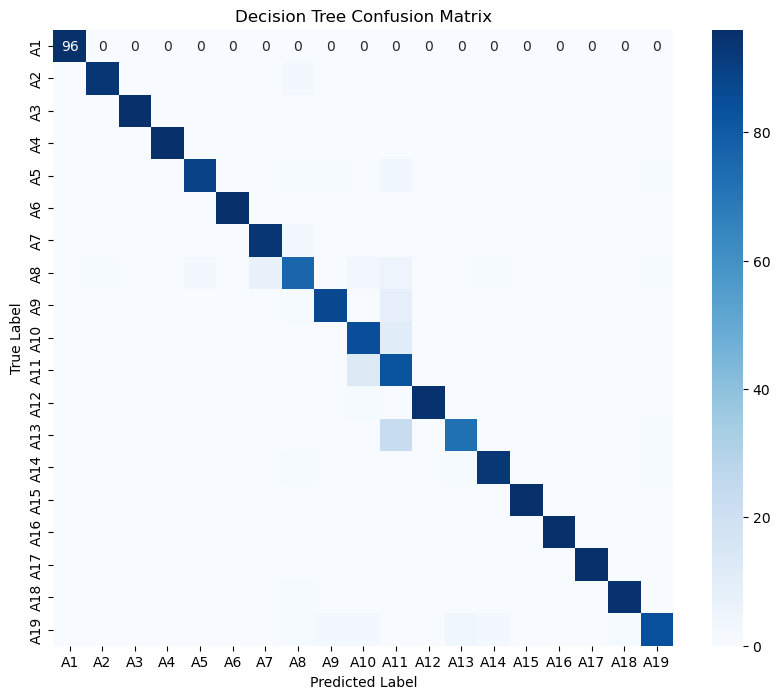

In [11]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Train and evaluate each model with confusion matrix
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy and Classification Report
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=ACTIVITIES))
    
    # Confusion Matrix
    print(f"{model_name} Confusion Matrix:")
    plot_confusion_matrix(y_test, y_pred, ACTIVITIES, title=f"{model_name} Confusion Matrix")


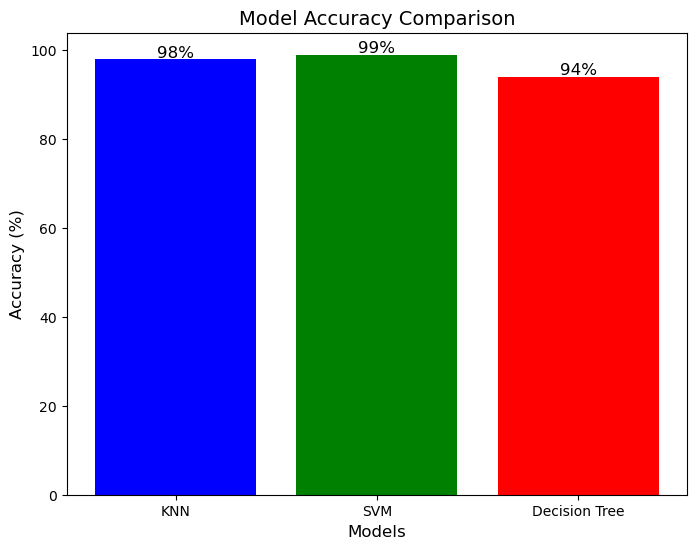

In [12]:
import matplotlib.pyplot as plt

# Data for the models and their accuracies
models = ['KNN', 'SVM', 'Decision Tree']
accuracies = [98, 99, 94]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

# Adding title and labels
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)

# Display the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f'{acc}%', ha='center', fontsize=12)

# Display the chart
plt.show()
